# SUMO

In this notebook, we will use the SUMO simulator to simulate a simple traffic scenario. We will use the TraCI API to interact with the simulation.

First lets define the needed imports and constants.


In [1]:
import random
import threading
from time import sleep

from lxml import etree

net_file = "BerlinSumo/osm.net.xml.gz"
route_file = "BerlinSumo/osm.passenger.trips.xml"
gml_file = "BerlinSumo/osm.net.gml"

Let's convert the net file to a gml file to visualize the network.

Now we can visualize the network using the GML file.

Let's do it using the `networkx` library and `matplotlib`.

Read the GML file and visualize the network.

In [2]:
import networkx as nx

def convert_to_simple_graph(input_path, output_path):
    try:
        # Parse the XML file
        tree = etree.parse(input_path)
        root = tree.getroot()

        G = nx.Graph()  # Create an undirected graph

        nodes = set()
        edges = set()

        # Extract edges
        for edge in root.findall("edge"):
            from_node_id = edge.attrib.get("from")  # Safely get the 'from' attribute
            to_node_id = edge.attrib.get("to")  # Safely get the 'to' attribute
            # print all attributes of the edge
            print(edge.attrib)
            # add from_node_id to nodes if it is not none
            if from_node_id is not None:
                nodes.add(from_node_id)
            if to_node_id is not None:
                nodes.add(to_node_id)

            # edge id
            edge_id = edge.attrib.get("id")

            # add the edge to the edges set
            edges.add((from_node_id, to_node_id, edge_id))

        for node in nodes:
            G.add_node(node)

        valid_edges = list()

        for edge in edges:
            if edge[0] is not None and edge[1] is not None:
                if len(edge) != 3:
                    print(f"Invalid edge: {edge}")
                    #G.add_edge(edge[0], edge[1],edge[2])
                G.add_edge(edge[0], edge[1])
                valid_edges.append(edge)

        # Write the graph to a GML file
        nx.write_gml(G, output_path)
        print(f"Graph conversion completed. GML file saved to: {output_path}")

        return valid_edges

    except Exception as e:
        print(f"Error during conversion: {e}")


sumo_edge_ids = convert_to_simple_graph(net_file, gml_file)
sumo_edge_ids


{'id': ':1001074218_0', 'function': 'internal'}
{'id': ':10189040386_0', 'function': 'internal'}
{'id': ':10189040387_0', 'function': 'internal'}
{'id': ':10287240229_0', 'function': 'internal'}
{'id': ':10287240229_1', 'function': 'internal'}
{'id': ':10287240229_3', 'function': 'internal'}
{'id': ':10287240229_2', 'function': 'internal'}
{'id': ':10287240230_0', 'function': 'internal'}
{'id': ':10287240230_1', 'function': 'internal'}
{'id': ':10287240230_2', 'function': 'internal'}
{'id': ':10287240230_3', 'function': 'internal'}
{'id': ':10298577286_0', 'function': 'internal'}
{'id': ':10556620135_0', 'function': 'internal'}
{'id': ':10556620135_1', 'function': 'internal'}
{'id': ':10723176862_0', 'function': 'internal'}
{'id': ':10880725066_0', 'function': 'internal'}
{'id': ':11062133273_0', 'function': 'internal'}
{'id': ':11062133273_1', 'function': 'internal'}
{'id': ':11124714790_0', 'function': 'internal'}
{'id': ':11124714790_2', 'function': 'internal'}
{'id': ':11392391984_

[('25662047',
  'cluster_4605644862_545110995_545119977_960119785',
  '-109902441'),
 ('283039345', '29207837', '4611708#0'),
 ('cluster_25665646_3602294175',
  'cluster_3378459427_3378459431',
  '1149417521#0'),
 ('29207825', '283038326', '375311154#1'),
 ('2247733130', '3345707083', '-508410318#2'),
 ('26708008', '29063088', '-1079386620#3'),
 ('25661397', '10880725066', '342968607#0'),
 ('3425667212', '26708008', '-85255869#2'),
 ('29207839', '29207838', '-1151333056'),
 ('8788585509', '25662928', '-1132162834#1'),
 ('11646819817', '25663714', '-4611711#1'),
 ('cluster_4605644862_545110995_545119977_960119785',
  '25661969',
  '191556835#0'),
 ('20246257', '25662705', '24242882#0'),
 ('4457861306', '11720027616', '4610524#0'),
 ('29194669', '160493853', '1126245113'),
 ('cluster_606986501_606986885', '10287240229', '1136657264#2'),
 ('283039347', '25663714', '23755961#0'),
 ('25663405', '25663747', '22972469#0'),
 ('25664841', '25664779', '-330840125#1'),
 ('1702616130', '25664713',

## Visualize the GML file

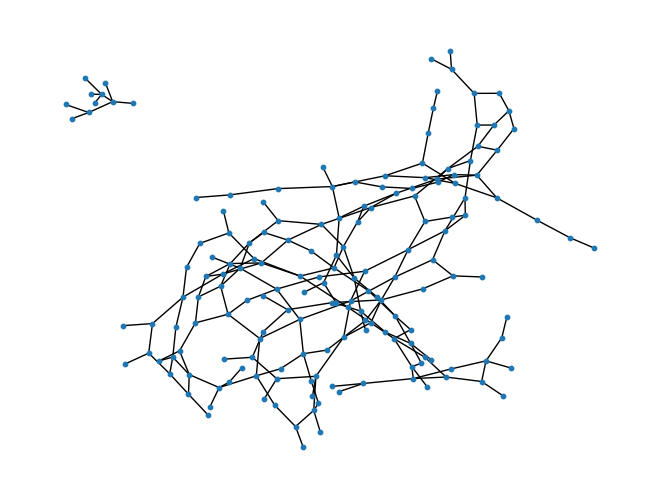

In [3]:
import matplotlib.pyplot as plt

G = nx.read_gml(gml_file)
# dont't show node names and make nodes smaller
nx.draw(G, with_labels=False, node_size=10)
plt.show()

Let's go with the SUMO simulation along with the TraCI API. And the PHE.

In [4]:
import PartialHomomorphyScheme
#
#phe_sim = PartialHomomorphyScheme.Simulation("Berlin", gml_file, quiet=False, sleep_time=0.2,
#                                             traffic_update_interval_in_seconds=20,
#                                             key_size=2048, sumo_edge_ids=sumo_edge_ids)
#
#def send_random_traffic_log(phe_sim: PartialHomomorphyScheme.Simulation):
#    while True:
#        if phe_sim.send_traffic_state:
#            random_edge = random.choice(sumo_edge_ids)
#            random_speed = random.randint(0, 30)
#            phe_sim.send_sumo_traffic(random_edge[2], random_speed)
#        sleep(0.1)
#
### run the above as a daemon thread
#send_traffic_thread = threading.Thread(target=send_random_traffic_log, args=(phe_sim,), daemon=True)
#send_traffic_thread.start()
#
#phe_sim.run()
#
#phe_sim.get_simulation_data()
#phe_sim.end_run()



Let's do sumo simulation.

In [5]:
import traci
import time

# Path to your SUMO configuration file
SUMO_CFG = "./BerlinSumo/osm.sumocfg"

phe_sim = PartialHomomorphyScheme.Simulation("Berlin", gml_file, quiet=False, sleep_time=0.2,
                                             traffic_update_interval_in_seconds=20,
                                             key_size=2048, sumo_edge_ids=sumo_edge_ids)


def run_simulation():
    # Start SUMO using the configuration file
    traci.start(["sumo", "-c", SUMO_CFG])

    simulation_time_step = 0
    interval = 10  # Interval in seconds

    try:
        while traci.simulation.getMinExpectedNumber() > 0:
            traci.simulationStep()  # Advance the simulation by one step

            execute_every_interval(simulation_time_step)

            simulation_time_step += 1
            time.sleep(1)  # Pause for real-time simulation
    except Exception as e:
        print(f"Error during simulation: {e}")
    finally:
        traci.close()  # Close SUMO connection


def execute_every_interval(simulation_time_step):
    print(f"Executing custom code at simulation time {simulation_time_step} seconds")
    # Retrieve and print the location of all vehicles
    vehicle_ids = traci.vehicle.getIDList()
    if not vehicle_ids:
        print("No vehicles in the simulation at this step.")
        return

    for veh_id in vehicle_ids:
        speed_m_s = traci.vehicle.getSpeed(veh_id)  # Speed in m/s
        speed_kmh = int(speed_m_s * 3.6)  # Convert to km/h
        position = traci.vehicle.getPosition(veh_id)  # Get the (x, y) coordinates
        edge_id = traci.vehicle.getRoadID(veh_id)
        print(f"Vehicle {veh_id}: Speed = {speed_kmh} km/h, Position = {position}, Edge = {edge_id}")
        phe_sim.send_sumo_traffic(sumo_edge_id=edge_id, speed=speed_kmh)

threading.Thread(target=run_simulation).start()
phe_sim.run()
phe_sim.get_simulation_data()
phe_sim.end_run()


facilitator: GlobalBlockchainNodeState.IDLE 104
Requesting to be a facilitator
 Retrying in 1 seconds
global node 0 accepted request for neighborhood Berlin
Local node 1: Facilitator request received. Now facilitator should respond
Local node 0: Facilitator request received. Now facilitator should respond
Local node 2: Facilitator request received. Now facilitator should respond
Local node 2: Facilitator accepted request.
Local node 1: Facilitator accepted request.
Local node 0: Facilitator accepted request.
facilitator: GlobalBlockchainNodeState.WAITING_FOR_FIRST_ENCRYPTED_AVERAGE_TRAFFIC 111
localBlockChainNode NeighborHoodState.FACILITATOR_REQUEST_ANSWERED 115
secondBridgeLocalToGlobal NeighborHoodState.FACILITATOR_REQUEST_ANSWERED 120
Now the sumo traffic should be sent by calling the send_sumo_traffic method
***Starting server on port 54626 ***
Loading net-file from './BerlinSumo/osm.net.xml.gz' ... done (47ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Exec

  9%|▊         | 19/219 [00:07<01:19,  2.51it/s]


KeyboardInterrupt: 